In [1]:
%load_ext watermark
%watermark -v -p pymc3,theano,pandas,numpy,mkl,arviz

CPython 3.6.10
IPython 7.13.0

pymc3 3.8
theano 1.0.4
pandas 1.0.3
numpy 1.18.1
mkl 2.3.0
arviz 0.7.0


# Bayesian AB testing: Or how to use PyMC3 to pick better ads (or anything)
Let's say you join Lego and you're asked to compare ads. 




In [2]:
from IPython.display import HTML
display(HTML("<table><tr><td><img src='https://images.duckduckgo.com/iu/?u=http%3A%2F%2Fdamewallis.files.wordpress.com%2F2011%2F02%2Flego-assinado_01-copy.jpg&f=1'></td><td><img src='https://images.duckduckgo.com/iu/?u=http%3A%2F%2F4.bp.blogspot.com%2F-Z7Lg2z4RaCI%2FTWUg-1-ezgI%2FAAAAAAAAAJM%2Fwijar1ScY0g%2Fs1600%2Flego-star-wars-flowers-print-ad.jpg&f=1'></td></tr></table>"))

,


Source - taken from online - the copyright belongs to the copyright holder - so probably Lego.

So we'll take 10% of all mobile traffic and do an an A/B test. 

On the left is the control, and on the right is the treatment. Your boss the head of Star Wars Lego Analytics thinks that the treatment will convert better. 

In [3]:
%matplotlib inline
import pymc3 as pm
import seaborn as sb
from theano import config
config.warn.round=False
import logging
(logging.getLogger('theano.gof.compilelock')
        .setLevel(logging.CRITICAL))
#imports and to ignore warnings for small models from Theano. Not very important, but improves the explanation.

n = 1000
obs_v1 = 680
obs_v2 = 720

So we've got 1000 users in both sets and obs_v1 is the number of people who click on the add for the control, and obs_v2 is the number people who click on the treatment. And they're all randomly allocated to each bucket. 

Next, we need to define our model. We'll use a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) for the priors and a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) for the likelihood. This is standard **best practice** for A/B tests in a Bayesian setting. The model needs to be defined within a context so place every command inside with pm.Model(): :

In [4]:
with pm.Model() as model: # context management
    # define our true effect of the ctr on ad v1 which is primed with a prior - a draw from Beta(2,2) 
    v1_ctr_probability = pm.Beta('v1_ctr_probability', alpha=2, beta=2)
    v2_ctr_probability = pm.Beta('v2_ctr_probability', alpha=2, beta=2)

    # define likelihood
    like_v1 = pm.Binomial('like_v1', n=n, p=v1_ctr_probability, observed=obs_v1)
    like_v2 = pm.Binomial('like_v2', n=n, p=v2_ctr_probability, observed=obs_v2)

alpha and beta are the parameters of the beta distribution (we choose the value 2 just to give a tiny preference to draw at first), **n** is the number of users in the experiment up to that moment, **p** is the probability of converting users and **observed** is the actual number of users who converted.

Now that we have setup the distributions for each variation, we can operate with them to come up with interesting results. Let's create two variables that will contain the difference and the relation between the variations.

From a student - Marko Pranjic 

Originally we used `prior_v1` and `prior_v2` as the variable name. 
- I would argue that variable name is a bit confusing. `prior_v1` is not a prior, it is a sample from a true effect that is being modeled. this true effect is 'primed' with a prior - a draw (Beta(2, 2))
the difference `prior_v2-prior_v1` is not part of the modelling - it is a way to inspect the difference between these two (true) effects. this difference is ploted (at the end) with a `ref_val=0`, meaning - plot this difference and plot `percentage below and above the values in ref_val`. value of zero means - there is no difference; we have shown that there is a significant probability that there is a difference between version1 and version2

- Based on this observation the names got changed to `v1_ctr_probability`

In [5]:
with model:
    # define metrics
    pm.Deterministic('difference', v2_ctr_probability - v1_ctr_probability)
    pm.Deterministic('relation', (v2_ctr_probability/v1_ctr_probability) - 1)

The final step is to do the inference step.

In [6]:
with model:
    # inference
    trace = pm.sample(draws=50000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v2_ctr_probability, v1_ctr_probability]
Sampling 4 chains, 0 divergences: 100%|██████████| 202000/202000 [00:43<00:00, 4640.55draws/s]
The acceptance probability does not match the target. It is 0.8857132439646715, but should be close to 0.8. Try to increase the number of tuning steps.


Let's look at the output of the trace - this tells us if our MCMC sampler works well.

We'll go into more detail on this in my course. But for now look for good 'hairy caterpillar' like traces on the right hand side. 

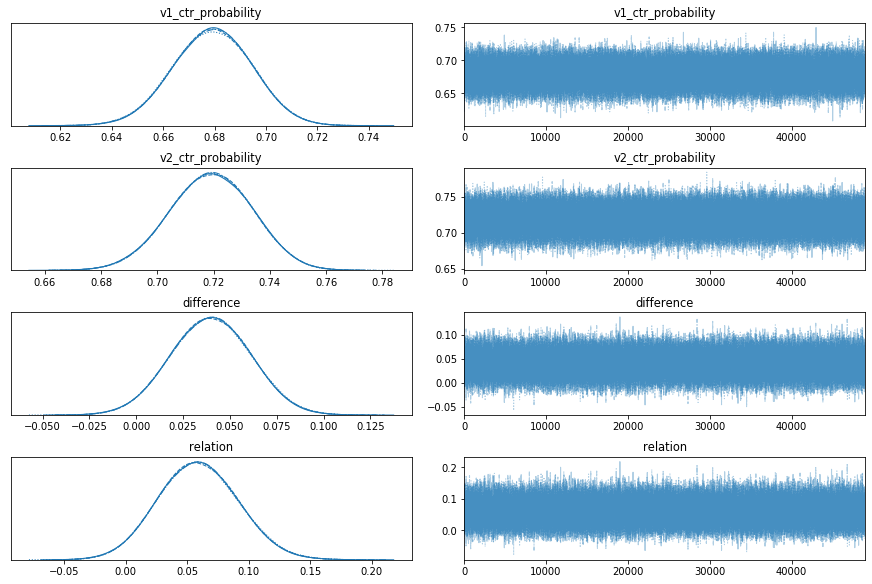

In [7]:
_ = pm.traceplot(trace[1000:])

On the left column you see the distributions and on the right column you see the sampling value for each step.

So the mixing looks good :) We can do some inference. 

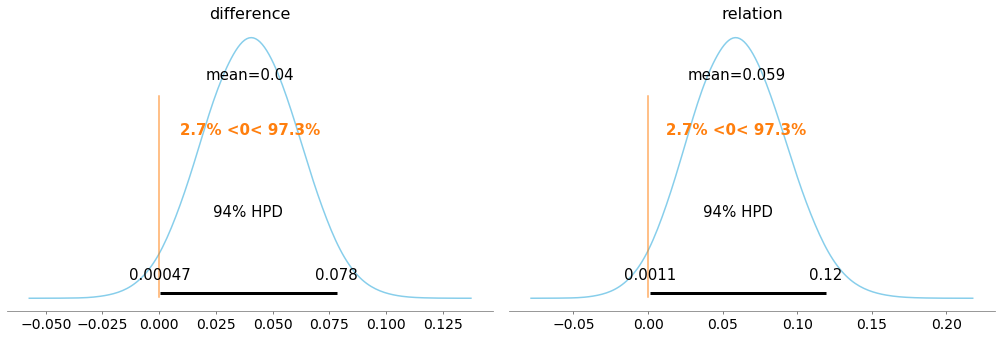

In [8]:
_ = pm.plot_posterior(trace[1000:], var_names=['difference', 'relation'], 
                      ref_val=0, color='#87ceeb')

## Results
Looking at the difference or relation histogram we see we have 97% confidence that variation 2 is better than variation 1. If we have earlier defined a significance level of 5%, we can declare a winner. 

We've confirmed the hypothesis and we can tell our head of Star Wars Analytics to run the second ad the red one. 